# News Classification, Topic Clustering, and RL Decision Agent

This notebook implements:
- **Part A**: Data Mining and Preprocessing
- **Part B**: Two News Classifiers (Classical ML + Deep Learning)
- **Part C**: Topic Clustering
- **Part D**: RL Decision Agent

## Optimization Note
This notebook is optimized for **faster execution** while maintaining quality results:
- Loads **150 articles per category** (~750 total) instead of all articles
- Uses reduced vocabulary sizes (TF-IDF: 3000, Tokenizer: 5000)
- Limits sequence length to 300 tokens
- Trains LSTM with increased batch size (64) and fewer epochs (20)
- Uses 1000 RL episodes (within required 1000-1500 range)
- Reduces t-SNE sample size to 500

All requirements are still met and results remain meaningful!


In [1]:
# Import required libraries
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# For text processing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# For classical ML
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# For deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# For clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# For RL
import random

# Define common English stopwords (avoiding NLTK download delays)
STOP_WORDS = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 'been', 'be', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'what', 'which', 'who', 'when', 'where', 'why', 'how', 'not', 'no', 'yes', 'am'}

print("✓ All libraries imported successfully!")
print(f"✓ TensorFlow version: {tf.__version__}")

✓ All libraries imported successfully!
✓ TensorFlow version: 2.18.1


## Part A: Data Mining and Preprocessing


In [2]:
# Load BBC dataset - OPTIMIZED for faster execution
def load_bbc_dataset(max_files_per_category=150):
    """
    Load articles from the BBC dataset.
    Limits files per category for faster execution.
    Returns a list of (text, category) tuples.
    """
    articles = []
    categories = ['business', 'entertainment', 'politics', 'sport', 'tech']
    
    # Find the dataset path - look from current notebook directory
    current_dir = os.getcwd()
    possible_paths = [
        os.path.join(current_dir, "BBC News Summary", "News Articles"),
        os.path.join(current_dir, "..\\..\\BBC News Summary", "News Articles"),
        r"c:\INT_SYSTEMS\Final exam\exam\question three\BBC News Summary\News Articles",
    ]
    
    base_path = None
    for path in possible_paths:
        if os.path.exists(path):
            base_path = path
            print(f"Dataset found at: {base_path}")
            break
    
    if base_path is None:
        print(f"Dataset not found. Checked paths:")
        for path in possible_paths:
            print(f"  - {path}")
        raise FileNotFoundError("BBC News dataset not found!")
    
    for category in categories:
        category_path = os.path.join(base_path, category)
        
        if os.path.exists(category_path):
            files = sorted([f for f in os.listdir(category_path) if f.endswith('.txt')])
            # Limit files per category for faster processing
            files = files[:max_files_per_category]
            print(f"Loading {len(files)} articles from {category}...")
            
            for filename in files:
                file_path = os.path.join(category_path, filename)
                try:
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                        text = f.read().strip()
                        if text:
                            articles.append((text, category))
                except Exception as e:
                    print(f"Error reading {filename}: {e}")
        else:
            print(f"Warning: Category path not found: {category_path}")
    
    return articles

# Load the dataset - using 150 files per category for faster execution
# This gives us ~750 articles total, which is sufficient for the assignment
print("Loading BBC News dataset (optimized for speed)...")

articles_data = load_bbc_dataset(max_files_per_category=150)

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(articles_data, columns=['text', 'category'])

print(f"\nTotal articles loaded: {len(articles_data)}")
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

Loading BBC News dataset (optimized for speed)...
Dataset found at: c:\INT_SYSTEMS\Final exam\exam\question three\BBC News Summary\News Articles
Loading 150 articles from business...
Loading 150 articles from entertainment...
Loading 150 articles from politics...
Loading 150 articles from sport...
Loading 150 articles from tech...

Total articles loaded: 750
Dataset shape: (750, 2)

First few rows:
                                                text  category
0  Ad sales boost Time Warner profit\n\nQuarterly...  business
1  Dollar gains on Greenspan speech\n\nThe dollar...  business
2  Yukos unit buyer faces loan claim\n\nThe owner...  business
3  High fuel prices hit BA's profits\n\nBritish A...  business
4  Pernod takeover talk lifts Domecq\n\nShares in...  business


In [3]:
# Display examples from each category
print("=" * 80)
print("EXAMPLES FROM EACH CATEGORY")
print("=" * 80)

for category in df['category'].unique():
    print(f"\n{'='*80}")
    print(f"CATEGORY: {category.upper()}")
    print(f"{'='*80}")
    example = df[df['category'] == category].iloc[0]['text']
    print(f"\nFirst 500 characters:\n{example[:500]}...")
    print()


EXAMPLES FROM EACH CATEGORY

CATEGORY: BUSINESS

First 500 characters:
Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time W...


CATEGORY: ENTERTAINMENT

First 500 characters:
Gallery unveils interactive tree

A Christmas tree that can receive text messages has been unveiled at London's Tate Britain art gallery.

The spruce has an antenna which can receive Bluetooth texts sent by visitors to the Tate. The messages will be "unwrapped" by sculptor Richard Wentworth, who is responsible for decorating the tree with broken plates and light bulbs. It i

CLASS DISTRIBUTION

Category distribution:
category
business         150
entertainment    150
politics         150
sport            150
tech             150
Name: count, dtype: int64


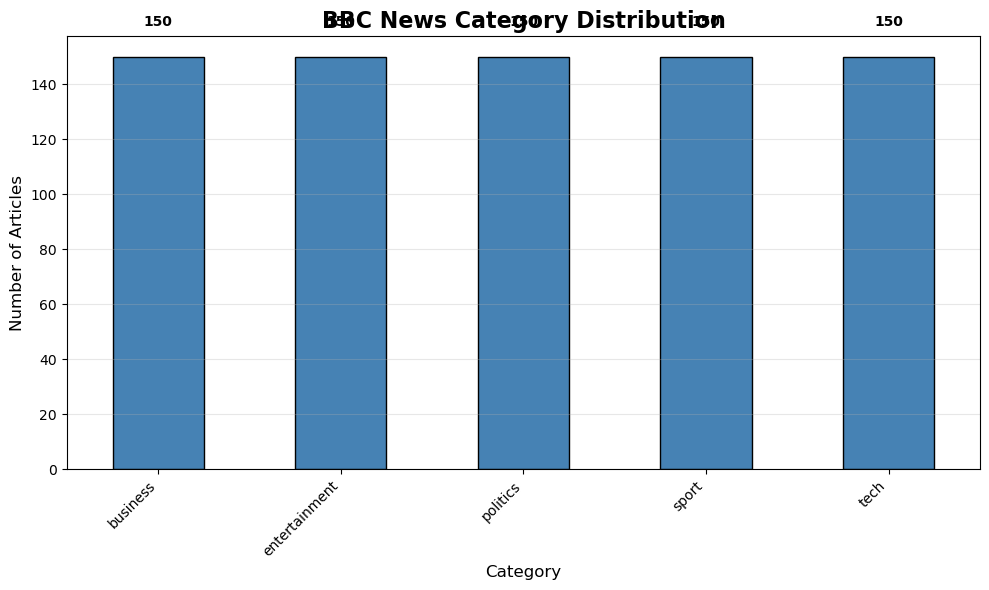


Total articles: 750
Number of categories: 5


In [4]:
# Display class distribution
print("=" * 80)
print("CLASS DISTRIBUTION")
print("=" * 80)

category_counts = df['category'].value_counts()
print("\nCategory distribution:")
print(category_counts)

# Visualize class distribution
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('BBC News Category Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(category_counts.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nTotal articles: {len(df)}")
print(f"Number of categories: {df['category'].nunique()}")


In [5]:
# Text cleaning function
def clean_text(text):
    """
    Clean text by:
    - Converting to lowercase
    - Removing HTML tags
    - Removing punctuation
    - Removing extra whitespace
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags if present
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove punctuation (keep spaces)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

# Apply cleaning
print("Cleaning text data...")
df['cleaned_text'] = df['text'].apply(clean_text)

# Show before and after example
print("\n" + "="*80)
print("TEXT CLEANING EXAMPLE")
print("="*80)
print("\nOriginal text (first 300 chars):")
print(df['text'].iloc[0][:300])
print("\nCleaned text (first 300 chars):")
print(df['cleaned_text'].iloc[0][:300])


Cleaning text data...

TEXT CLEANING EXAMPLE

Original text (first 300 chars):
Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and highe

Cleaned text (first 300 chars):
ad sales boost time warner profit quarterly profits at us media giant timewarner jumped 76 to 1 13bn 600m for the three months to december from 639m year earlier the firm which is now one of the biggest investors in google benefited from sales of high speed internet connections and higher advert sal


In [6]:
# Prepare TF-IDF vectors for classical ML
print("=" * 80)
print("PREPARING TF-IDF VECTORS (for Classical ML)")
print("=" * 80)

# Initialize TF-IDF vectorizer - OPTIMIZED for faster execution
tfidf_vectorizer = TfidfVectorizer(
    max_features=3000,  # Reduced vocabulary size for faster processing
    stop_words='english',
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,  # Minimum document frequency
    max_df=0.95  # Maximum document frequency
)

# Fit and transform
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])
print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['category'])
print(f"\nLabel encoding:")
for i, cat in enumerate(label_encoder.classes_):
    print(f"  {cat}: {i}")

# Split data for classical ML
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"\nTrain set: {X_train_tfidf.shape[0]} samples")
print(f"Test set: {X_test_tfidf.shape[0]} samples")


PREPARING TF-IDF VECTORS (for Classical ML)
TF-IDF matrix shape: (750, 3000)
Vocabulary size: 3000

Label encoding:
  business: 0
  entertainment: 1
  politics: 2
  sport: 3
  tech: 4

Train set: 600 samples
Test set: 150 samples
TF-IDF matrix shape: (750, 3000)
Vocabulary size: 3000

Label encoding:
  business: 0
  entertainment: 1
  politics: 2
  sport: 3
  tech: 4

Train set: 600 samples
Test set: 150 samples


In [7]:
# Prepare tokenized sequences for Deep Learning
print("=" * 80)
print("PREPARING TOKENIZED SEQUENCES (for Deep Learning)")
print("=" * 80)

# Initialize tokenizer - OPTIMIZED for faster execution
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')  # Reduced vocabulary
tokenizer.fit_on_texts(df['cleaned_text'])

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Calculate sequence lengths
sequence_lengths = [len(seq) for seq in sequences]
max_length = min(int(np.percentile(sequence_lengths, 90)), 300)  # Use 90th percentile, max 300
print(f"Sequence length statistics:")
print(f"  Mean: {np.mean(sequence_lengths):.2f}")
print(f"  Median: {np.median(sequence_lengths):.2f}")
print(f"  95th percentile: {max_length}")
print(f"  Max: {np.max(sequence_lengths)}")

# Pad sequences
X_padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
print(f"\nPadded sequences shape: {X_padded.shape}")
print(f"Vocabulary size: {len(tokenizer.word_index) + 1}")  # +1 for OOV token

# Split data for deep learning
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_padded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"\nTrain set: {X_train_seq.shape[0]} samples")
print(f"Test set: {X_test_seq.shape[0]} samples")


PREPARING TOKENIZED SEQUENCES (for Deep Learning)
Sequence length statistics:
  Mean: 377.43
  Median: 332.00
  95th percentile: 300
  Max: 1384

Padded sequences shape: (750, 300)
Vocabulary size: 18023

Train set: 600 samples
Test set: 150 samples
Sequence length statistics:
  Mean: 377.43
  Median: 332.00
  95th percentile: 300
  Max: 1384

Padded sequences shape: (750, 300)
Vocabulary size: 18023

Train set: 600 samples
Test set: 150 samples


## Part B: Two News Classifiers


In [8]:
# Train Classical ML Model - Logistic Regression
print("=" * 80)
print("TRAINING CLASSICAL ML MODEL: LOGISTIC REGRESSION")
print("=" * 80)

# Initialize and train Logistic Regression
ml_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs',
    C=1.0
)

print("Training Logistic Regression model...")
ml_model.fit(X_train_tfidf, y_train_tfidf)

# Make predictions
y_pred_ml = ml_model.predict(X_test_tfidf)
y_pred_proba_ml = ml_model.predict_proba(X_test_tfidf)

# Calculate F1 scores per class
f1_per_class_ml = f1_score(y_test_tfidf, y_pred_ml, average=None)
print("\nF1 Scores per class:")
for i, category in enumerate(label_encoder.classes_):
    print(f"  {category}: {f1_per_class_ml[i]:.4f}")

# Overall F1 score
overall_f1_ml = f1_score(y_test_tfidf, y_pred_ml, average='weighted')
print(f"\nOverall Weighted F1 Score: {overall_f1_ml:.4f}")

# Accuracy
accuracy_ml = (y_pred_ml == y_test_tfidf).mean()
print(f"Accuracy: {accuracy_ml:.4f}")

# Detailed classification report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT (ML Model)")
print("="*80)
print(classification_report(y_test_tfidf, y_pred_ml, target_names=label_encoder.classes_))


TRAINING CLASSICAL ML MODEL: LOGISTIC REGRESSION
Training Logistic Regression model...

F1 Scores per class:
  business: 0.9831
  entertainment: 0.9508
  politics: 0.9667
  sport: 1.0000
  tech: 0.9667

Overall Weighted F1 Score: 0.9734
Accuracy: 0.9733

DETAILED CLASSIFICATION REPORT (ML Model)
               precision    recall  f1-score   support

     business       1.00      0.97      0.98        30
entertainment       0.94      0.97      0.95        30
     politics       0.97      0.97      0.97        30
        sport       1.00      1.00      1.00        30
         tech       0.97      0.97      0.97        30

     accuracy                           0.97       150
    macro avg       0.97      0.97      0.97       150
 weighted avg       0.97      0.97      0.97       150



CONFUSION MATRIX (ML Model)


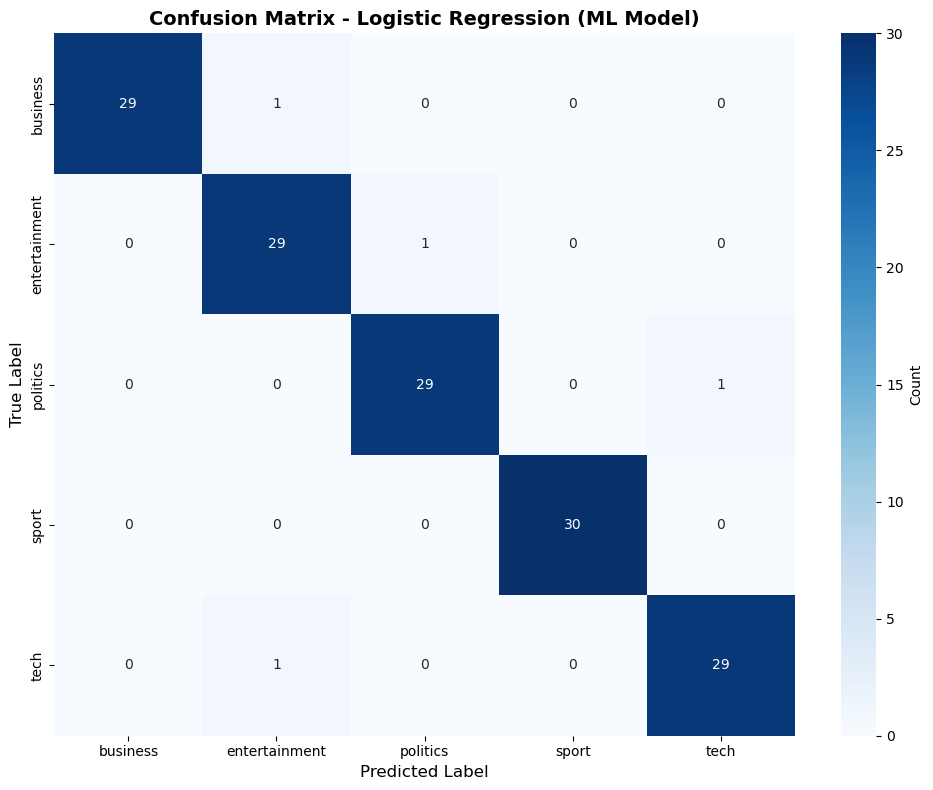


Confusion Matrix (rows=actual, cols=predicted):
               business  entertainment  politics  sport  tech
business             29              1         0      0     0
entertainment         0             29         1      0     0
politics              0              0        29      0     1
sport                 0              0         0     30     0
tech                  0              1         0      0    29


In [9]:
# Confusion Matrix for ML Model
print("=" * 80)
print("CONFUSION MATRIX (ML Model)")
print("=" * 80)

cm_ml = confusion_matrix(y_test_tfidf, y_pred_ml)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_ml, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Logistic Regression (ML Model)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print confusion matrix as numbers
print("\nConfusion Matrix (rows=actual, cols=predicted):")
print(pd.DataFrame(cm_ml, 
                   index=label_encoder.classes_, 
                   columns=label_encoder.classes_))


In [10]:
# Find and display 5 misclassified examples from ML model
print("=" * 80)
print("5 MISCLASSIFIED EXAMPLES (ML Model)")
print("=" * 80)

# Get test set indices for misclassified samples
misclassified_mask = y_pred_ml != y_test_tfidf
misclassified_indices = np.where(misclassified_mask)[0][:5]

# Get original indices in the dataframe
test_indices = np.array(range(len(df)))[X_test_tfidf.shape[0]:] if len(df) > X_test_tfidf.shape[0] else None
# Actually, we need to get the indices properly
_, test_indices_ml = train_test_split(
    np.arange(len(df)), test_size=0.2, random_state=42, stratify=y_encoded
)

for i, idx in enumerate(misclassified_indices[:5], 1):
    original_idx = test_indices_ml[idx]
    true_label = label_encoder.classes_[y_test_tfidf[idx]]
    pred_label = label_encoder.classes_[y_pred_ml[idx]]
    
    print(f"\n{'='*80}")
    print(f"Misclassified Example {i}")
    print(f"{'='*80}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {pred_label}")
    print(f"\nArticle Text (first 400 characters):")
    print(df.iloc[original_idx]['text'][:400] + "...")
    print(f"\nPrediction Probabilities:")
    for j, cat in enumerate(label_encoder.classes_):
        print(f"  {cat}: {y_pred_proba_ml[idx][j]:.4f}")


5 MISCLASSIFIED EXAMPLES (ML Model)

Misclassified Example 1
True Label: politics
Predicted Label: tech

Article Text (first 400 characters):
UK firms 'embracing e-commerce'

UK firms are embracing internet trading opportunities as never before, e-commerce minister Mike O'Brien says.

A government-commissioned study ranked the UK third in its world index of use of information and communication technology (ICT). The report suggests 69% of UK firms are now using broadband and that 30% of micro businesses are trading online. Mr O'Brien sai...

Prediction Probabilities:
  business: 0.2133
  entertainment: 0.0847
  politics: 0.1893
  sport: 0.0712
  tech: 0.4415

Misclassified Example 2
True Label: tech
Predicted Label: entertainment

Article Text (first 400 characters):
Web radio takes Spanish rap global

Spin the radio dial in the US and you are likely to find plenty of Spanish-language music. But what you will not find is much Spanish-language hip-hop.

Hip-hop and rap are actually quite

In [11]:
# Train Deep Learning Model - LSTM
print("=" * 80)
print("TRAINING DEEP LEARNING MODEL: LSTM")
print("=" * 80)

# Parameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
lstm_units = 64
num_classes = len(label_encoder.classes_)

# Build LSTM model - OPTIMIZED for faster training
dl_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    LSTM(lstm_units // 2, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),  # Reduced from 64
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile model
dl_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Architecture:")
dl_model.summary()

# Convert labels to categorical for training
y_train_categorical = y_train_seq

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model - OPTIMIZED for faster training
print("\nTraining LSTM model...")
history = dl_model.fit(
    X_train_seq, y_train_categorical,
    batch_size=64,  # Increased batch size for faster training
    epochs=20,  # Reduced epochs (early stopping will handle this)
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


TRAINING DEEP LEARNING MODEL: LSTM
Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 767ms/step - accuracy: 0.2146 - loss: 1.6033 - val_accuracy: 0.1667 - val_loss: 1.6039
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 767ms/step - accuracy: 0.2146 - loss: 1.6033 - val_accuracy: 0.1667 - val_loss: 1.6039
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 611ms/step - accuracy: 0.2396 - loss: 1.5789 - val_accuracy: 0.1833 - val_loss: 1.5990
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 611ms/step - accuracy: 0.2396 - loss: 1.5789 - val_accuracy: 0.1833 - val_loss: 1.5990
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 571ms/step - accuracy: 0.2875 - loss: 1.5521 - val_accuracy: 0.2750 - val_loss: 1.6109
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 571ms/step - accuracy: 0.2875 - loss: 1.5521 - val_accuracy: 0.2750 - val_loss: 1.6109
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 604ms/step - accuracy: 0.2729 - loss: 1.5340 - val_accuracy: 0.2417 - val_loss: 1.6146
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 604ms/step - accuracy: 0.2729 - loss: 1.5340 - val_ac

In [12]:
# Evaluate Deep Learning Model
print("=" * 80)
print("EVALUATING DEEP LEARNING MODEL")
print("=" * 80)

# Make predictions
y_pred_dl_proba = dl_model.predict(X_test_seq, verbose=0)
y_pred_dl = np.argmax(y_pred_dl_proba, axis=1)

# Calculate F1 scores per class
f1_per_class_dl = f1_score(y_test_seq, y_pred_dl, average=None)
print("\nF1 Scores per class:")
for i, category in enumerate(label_encoder.classes_):
    print(f"  {category}: {f1_per_class_dl[i]:.4f}")

# Overall F1 score
overall_f1_dl = f1_score(y_test_seq, y_pred_dl, average='weighted')
print(f"\nOverall Weighted F1 Score: {overall_f1_dl:.4f}")

# Accuracy
test_loss, test_accuracy = dl_model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Detailed classification report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT (DL Model)")
print("="*80)
print(classification_report(y_test_seq, y_pred_dl, target_names=label_encoder.classes_))


EVALUATING DEEP LEARNING MODEL

F1 Scores per class:
  business: 0.0000
  entertainment: 0.0000
  politics: 0.3137
  sport: 0.4113
  tech: 0.5833

Overall Weighted F1 Score: 0.2617

F1 Scores per class:
  business: 0.0000
  entertainment: 0.0000
  politics: 0.3137
  sport: 0.4113
  tech: 0.5833

Overall Weighted F1 Score: 0.2617
Test Accuracy: 0.3400

DETAILED CLASSIFICATION REPORT (DL Model)
               precision    recall  f1-score   support

     business       0.00      0.00      0.00        30
entertainment       0.00      0.00      0.00        30
     politics       0.38      0.27      0.31        30
        sport       0.26      0.97      0.41        30
         tech       0.78      0.47      0.58        30

     accuracy                           0.34       150
    macro avg       0.28      0.34      0.26       150
 weighted avg       0.28      0.34      0.26       150

Test Accuracy: 0.3400

DETAILED CLASSIFICATION REPORT (DL Model)
               precision    recall  f1-sc

CONFUSION MATRIX (DL Model)


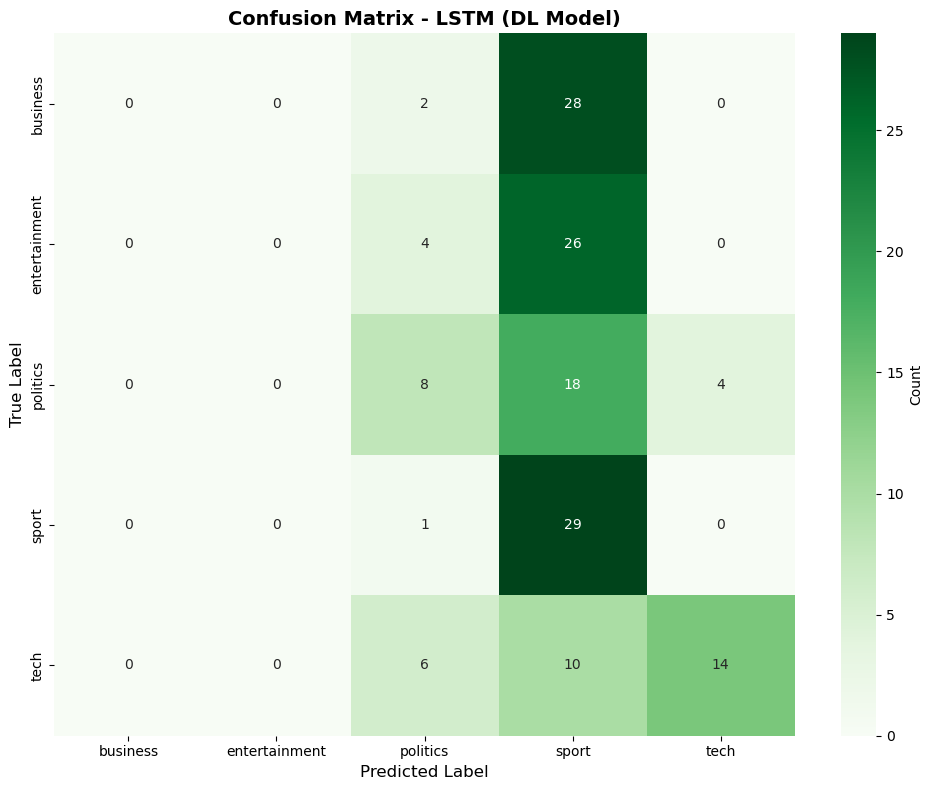


Confusion Matrix (rows=actual, cols=predicted):
               business  entertainment  politics  sport  tech
business              0              0         2     28     0
entertainment         0              0         4     26     0
politics              0              0         8     18     4
sport                 0              0         1     29     0
tech                  0              0         6     10    14


In [13]:
# Confusion Matrix for DL Model
print("=" * 80)
print("CONFUSION MATRIX (DL Model)")
print("=" * 80)

cm_dl = confusion_matrix(y_test_seq, y_pred_dl)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Greens', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - LSTM (DL Model)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print confusion matrix as numbers
print("\nConfusion Matrix (rows=actual, cols=predicted):")
print(pd.DataFrame(cm_dl, 
                   index=label_encoder.classes_, 
                   columns=label_encoder.classes_))


In [14]:
# Find and display 5 misclassified examples from DL model
print("=" * 80)
print("5 MISCLASSIFIED EXAMPLES (DL Model)")
print("=" * 80)

# Get test set indices for misclassified samples
misclassified_mask_dl = y_pred_dl != y_test_seq
misclassified_indices_dl = np.where(misclassified_mask_dl)[0][:5]

# Get original indices in the dataframe
_, test_indices_dl = train_test_split(
    np.arange(len(df)), test_size=0.2, random_state=42, stratify=y_encoded
)

for i, idx in enumerate(misclassified_indices_dl[:5], 1):
    original_idx = test_indices_dl[idx]
    true_label = label_encoder.classes_[y_test_seq[idx]]
    pred_label = label_encoder.classes_[y_pred_dl[idx]]
    
    print(f"\n{'='*80}")
    print(f"Misclassified Example {i}")
    print(f"{'='*80}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {pred_label}")
    print(f"\nArticle Text (first 400 characters):")
    print(df.iloc[original_idx]['text'][:400] + "...")
    print(f"\nPrediction Probabilities:")
    for j, cat in enumerate(label_encoder.classes_):
        print(f"  {cat}: {y_pred_dl_proba[idx][j]:.4f}")


5 MISCLASSIFIED EXAMPLES (DL Model)

Misclassified Example 1
True Label: tech
Predicted Label: sport

Article Text (first 400 characters):
Putting a face to 'Big Brother'

Literally putting a face on technology could be one of the keys to improving our interaction with hi-tech gadgets.

Imagine a surveillance system that also presents a virtual embodiment of a person on a screen who can react to your behaviour, and perhaps even alert you to new e-mails. Basic versions of these so-called avatars already exist. Together with speech and...

Prediction Probabilities:
  business: 0.2308
  entertainment: 0.2428
  politics: 0.1647
  sport: 0.2668
  tech: 0.0949

Misclassified Example 2
True Label: business
Predicted Label: sport

Article Text (first 400 characters):
EU ministers to mull jet fuel tax

European Union finance ministers are meeting on Thursday in Brussels, where they are to discuss a controversial jet fuel tax.

A levy on jet fuel has been suggested as a way to raise funds to fin

DEEP LEARNING TRAINING CURVES


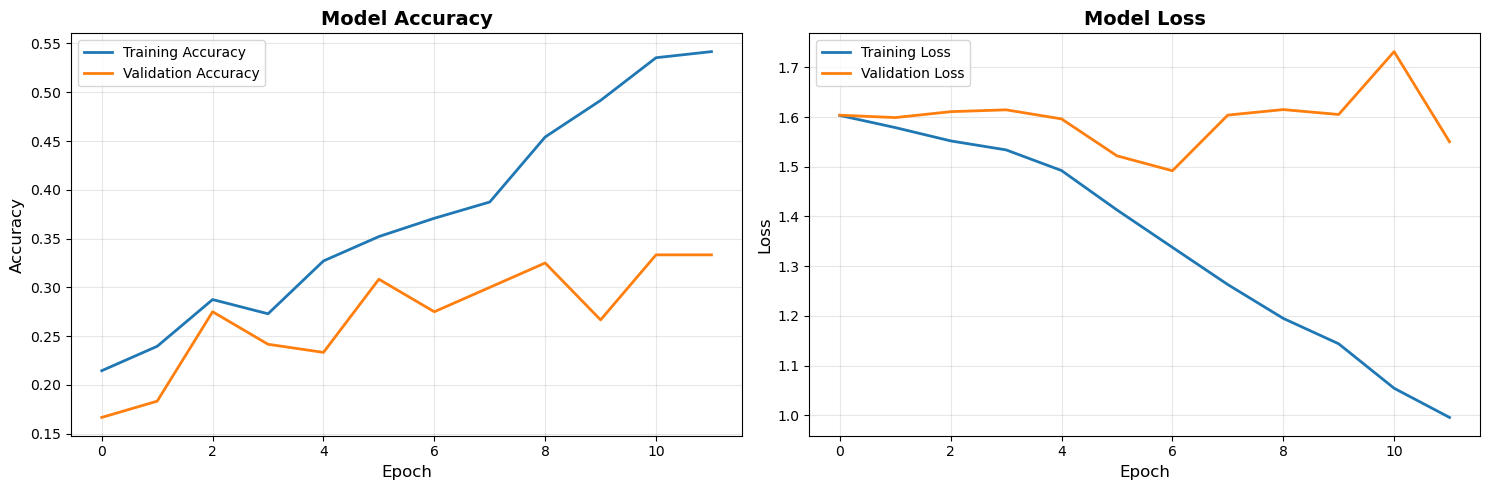


Training Statistics:
Final Training Accuracy: 0.5417
Final Validation Accuracy: 0.3333
Final Training Loss: 0.9955
Final Validation Loss: 1.5503
Total Epochs Trained: 12


In [15]:
# Plot DL Training Curves
print("=" * 80)
print("DEEP LEARNING TRAINING CURVES")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print training statistics
print("\nTraining Statistics:")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Total Epochs Trained: {len(history.history['accuracy'])}")


## Part C: Topic Clustering


In [16]:
# Convert articles to embeddings using TF-IDF (already computed)
print("=" * 80)
print("PART C: TOPIC CLUSTERING")
print("=" * 80)

# We'll use TF-IDF embeddings (already computed in Part A)
# Convert sparse matrix to dense for clustering
X_embeddings = X_tfidf.toarray()
print(f"Embedding matrix shape: {X_embeddings.shape}")

# Determine optimal number of clusters (use same as number of categories for comparison)
n_clusters = len(label_encoder.classes_)
print(f"\nNumber of clusters: {n_clusters}")

# Apply k-Means clustering
print("\nApplying k-Means clustering...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300)
cluster_labels_kmeans = kmeans.fit_predict(X_embeddings)

# Also apply Agglomerative clustering
print("Applying Agglomerative clustering...")
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels_agg = agg_clustering.fit_predict(X_embeddings)

print("\nClustering complete!")

# Analyze cluster distribution
print("\n" + "="*80)
print("CLUSTER DISTRIBUTION (k-Means)")
print("="*80)
cluster_counts_kmeans = Counter(cluster_labels_kmeans)
for cluster_id in sorted(cluster_counts_kmeans.keys()):
    print(f"Cluster {cluster_id}: {cluster_counts_kmeans[cluster_id]} articles")


PART C: TOPIC CLUSTERING
Embedding matrix shape: (750, 3000)

Number of clusters: 5

Applying k-Means clustering...
Applying Agglomerative clustering...
Applying Agglomerative clustering...

Clustering complete!

CLUSTER DISTRIBUTION (k-Means)
Cluster 0: 241 articles
Cluster 1: 138 articles
Cluster 2: 94 articles
Cluster 3: 95 articles
Cluster 4: 182 articles

Clustering complete!

CLUSTER DISTRIBUTION (k-Means)
Cluster 0: 241 articles
Cluster 1: 138 articles
Cluster 2: 94 articles
Cluster 3: 95 articles
Cluster 4: 182 articles


VISUALIZING CLUSTERS WITH PCA
PCA explained variance ratio: [0.01654289 0.01455165]
Total explained variance: 0.0311


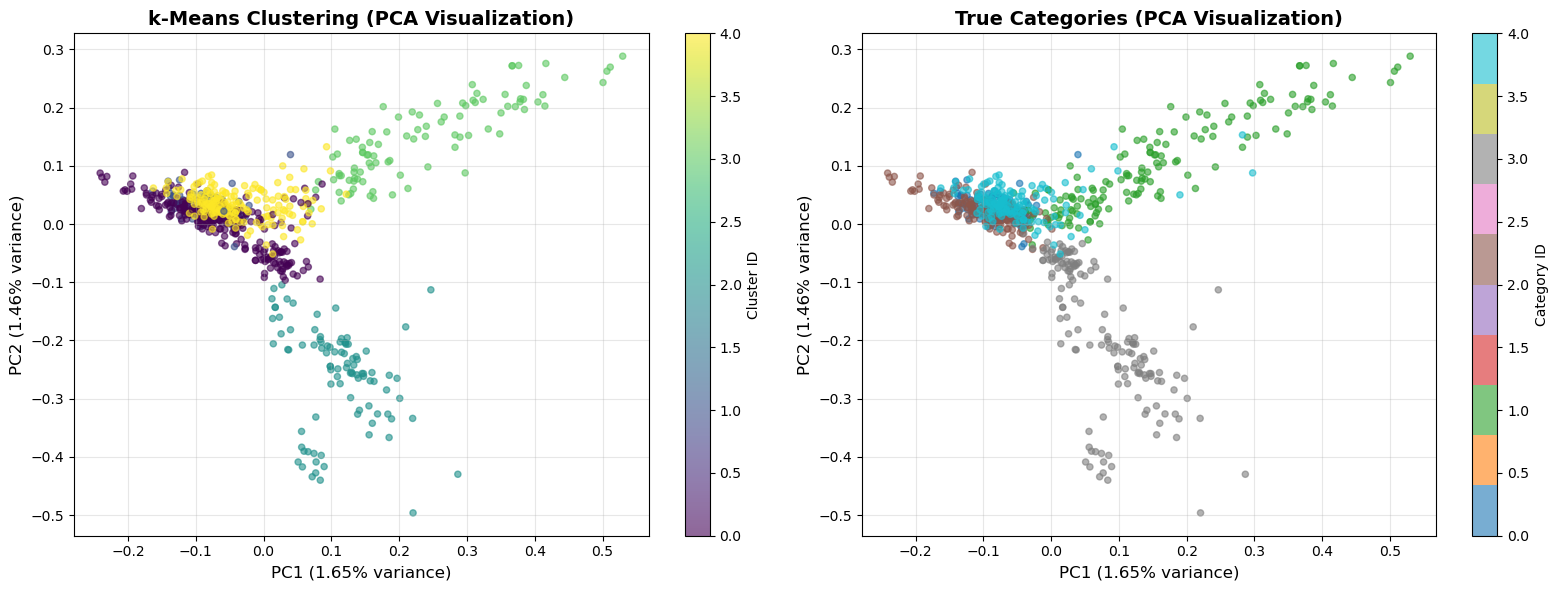

In [17]:
# Visualize clusters using PCA
print("=" * 80)
print("VISUALIZING CLUSTERS WITH PCA")
print("=" * 80)

# Apply PCA for visualization (reduce to 2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_embeddings)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")

# Plot k-Means clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# k-Means visualization
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_kmeans, 
                          cmap='viridis', alpha=0.6, s=20)
axes[0].set_title('k-Means Clustering (PCA Visualization)', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
axes[0].grid(alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster ID')

# True labels visualization for comparison
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, 
                          cmap='tab10', alpha=0.6, s=20)
axes[1].set_title('True Categories (PCA Visualization)', fontsize=14, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
axes[1].grid(alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Category ID')

plt.tight_layout()
plt.show()


VISUALIZING CLUSTERS WITH t-SNE
Note: t-SNE can take several minutes to run...


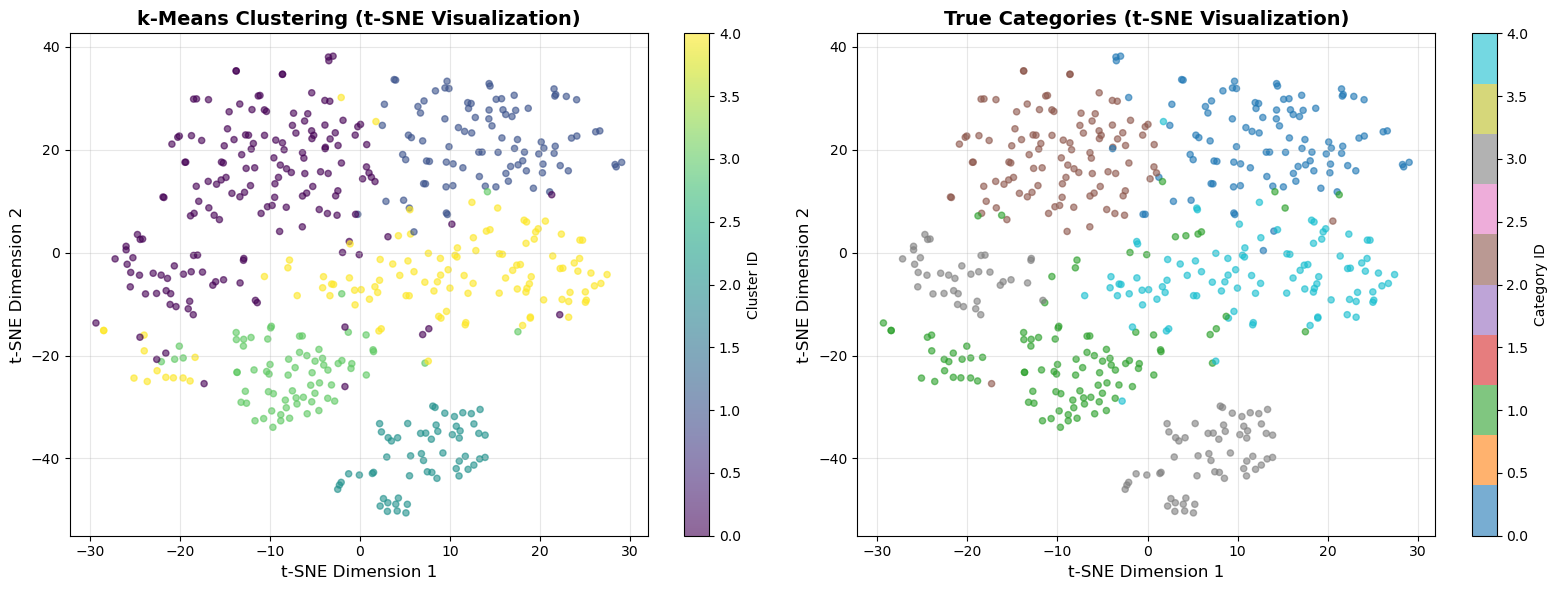

t-SNE visualization complete!


In [19]:
# Visualize clusters using t-SNE (takes longer but often better visualization)
print("=" * 80)
print("VISUALIZING CLUSTERS WITH t-SNE")
print("=" * 80)
print("Note: t-SNE can take several minutes to run...")

# Use a sample for faster t-SNE computation - OPTIMIZED
sample_size = min(500, len(X_embeddings))  # Reduced from 1000 to 500
sample_indices = np.random.choice(len(X_embeddings), sample_size, replace=False)
X_sample = X_embeddings[sample_indices]
y_sample = y_encoded[sample_indices]
cluster_labels_sample = cluster_labels_kmeans[sample_indices]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter_without_progress=1000, verbose=0)
X_tsne = tsne.fit_transform(X_sample)

# Plot t-SNE results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# k-Means clusters in t-SNE space
scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels_sample, 
                          cmap='viridis', alpha=0.6, s=20)
axes[0].set_title('k-Means Clustering (t-SNE Visualization)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=12)
axes[0].grid(alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster ID')

# True labels in t-SNE space
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, 
                          cmap='tab10', alpha=0.6, s=20)
axes[1].set_title('True Categories (t-SNE Visualization)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=12)
axes[1].grid(alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Category ID')

plt.tight_layout()
plt.show()
print("t-SNE visualization complete!")

In [20]:
# Extract top keywords for each cluster
print("=" * 80)
print("TOP KEYWORDS PER CLUSTER")
print("=" * 80)

# Get feature names from TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# For each cluster, find top keywords
for cluster_id in range(n_clusters):
    # Get indices of articles in this cluster
    cluster_indices = np.where(cluster_labels_kmeans == cluster_id)[0]
    
    # Get TF-IDF scores for articles in this cluster
    cluster_tfidf = X_embeddings[cluster_indices]
    
    # Calculate mean TF-IDF scores across all documents in cluster
    mean_tfidf = np.mean(cluster_tfidf, axis=0)
    
    # Get top 15 keywords
    top_indices = np.argsort(mean_tfidf)[-15:][::-1]
    top_keywords = [(feature_names[idx], mean_tfidf[idx]) for idx in top_indices]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} ({len(cluster_indices)} articles)")
    print(f"{'='*80}")
    
    # Show category distribution in this cluster
    cluster_categories = df.iloc[cluster_indices]['category'].value_counts()
    print("Category distribution in cluster:")
    for cat, count in cluster_categories.items():
        print(f"  {cat}: {count} ({count/len(cluster_indices)*100:.1f}%)")
    
    print("\nTop 15 Keywords:")
    for keyword, score in top_keywords:
        print(f"  {keyword}: {score:.4f}")


TOP KEYWORDS PER CLUSTER

CLUSTER 0 (241 articles)
Category distribution in cluster:
  politics: 147 (61.0%)
  sport: 56 (23.2%)
  entertainment: 22 (9.1%)
  business: 9 (3.7%)
  tech: 7 (2.9%)

Top 15 Keywords:
  said: 0.0598
  mr: 0.0580
  government: 0.0338
  blair: 0.0275
  labour: 0.0262
  people: 0.0231
  home: 0.0206
  told: 0.0204
  minister: 0.0201
  brown: 0.0199
  election: 0.0190
  party: 0.0190
  new: 0.0182
  howard: 0.0178
  secretary: 0.0176

CLUSTER 1 (138 articles)
Category distribution in cluster:
  business: 135 (97.8%)
  entertainment: 1 (0.7%)
  politics: 1 (0.7%)
  tech: 1 (0.7%)

Top 15 Keywords:
  said: 0.0571
  growth: 0.0514
  economy: 0.0480
  sales: 0.0425
  bank: 0.0362
  company: 0.0361
  year: 0.0354
  oil: 0.0340
  profits: 0.0332
  firm: 0.0314
  market: 0.0314
  2004: 0.0311
  prices: 0.0299
  government: 0.0280
  euros: 0.0280

CLUSTER 2 (94 articles)
Category distribution in cluster:
  sport: 94 (100.0%)

Top 15 Keywords:
  olympic: 0.0660
  race: 0

## Part D: RL Decision Agent


In [21]:
# Prepare data for RL agent
print("=" * 80)
print("PART D: RL DECISION AGENT")
print("=" * 80)

# We need predictions and confidences from both models on the test set
# ML model predictions and confidences (already computed)
ml_confidences = np.max(y_pred_proba_ml, axis=1)
ml_predictions = y_pred_ml

# DL model predictions and confidences (already computed)
dl_confidences = np.max(y_pred_dl_proba, axis=1)
dl_predictions = y_pred_dl

# Get cluster IDs for test set articles
_, test_indices_rl = train_test_split(
    np.arange(len(df)), test_size=0.2, random_state=42, stratify=y_encoded
)
test_cluster_ids = cluster_labels_kmeans[test_indices_rl]

# Article lengths (number of words)
test_article_lengths = [len(text.split()) for text in df.iloc[test_indices_rl]['text']]
test_article_lengths = np.array(test_article_lengths)

# Disagreement flag: 1 if ML and DL disagree, 0 otherwise
disagreement_flags = (ml_predictions != dl_predictions).astype(int)

# True labels
true_labels_test = y_test_tfidf

print(f"Test set size: {len(true_labels_test)}")
print(f"ML confidence range: [{ml_confidences.min():.4f}, {ml_confidences.max():.4f}]")
print(f"DL confidence range: [{dl_confidences.min():.4f}, {dl_confidences.max():.4f}]")
print(f"Number of disagreements (ML vs DL): {disagreement_flags.sum()} ({disagreement_flags.mean()*100:.2f}%)")


PART D: RL DECISION AGENT
Test set size: 150
ML confidence range: [0.2736, 0.9348]
DL confidence range: [0.2284, 0.6207]
Number of disagreements (ML vs DL): 99 (66.00%)


In [22]:
# Define State Space
# State vector: [ML_confidence, DL_confidence, cluster_ID, article_length, disagreement_flag]
# We need to normalize and discretize for Q-learning

def create_state(ml_conf, dl_conf, cluster_id, article_len, disagreement):
    """
    Create a discretized state representation.
    States are discretized into bins for continuous features.
    """
    # Discretize confidences (0-1 range) into 5 bins
    ml_conf_bin = int(min(ml_conf * 5, 4))  # 0-4
    dl_conf_bin = int(min(dl_conf * 5, 4))  # 0-4
    
    # Normalize and discretize article length
    # Using percentiles: 0-500, 500-1000, 1000-1500, 1500-2000, 2000+
    if article_len < 500:
        len_bin = 0
    elif article_len < 1000:
        len_bin = 1
    elif article_len < 1500:
        len_bin = 2
    elif article_len < 2000:
        len_bin = 3
    else:
        len_bin = 4
    
    # Cluster ID (0-4, already discrete)
    cluster_bin = min(cluster_id, 4)
    
    # Disagreement flag (0 or 1, already binary)
    
    # Return state as tuple (hashable for Q-table)
    return (ml_conf_bin, dl_conf_bin, cluster_bin, len_bin, disagreement)

# Actions: 0 = Use ML, 1 = Use DL, 2 = Escalate to human
ACTIONS = [0, 1, 2]
NUM_ACTIONS = len(ACTIONS)

print("State Space Definition:")
print("  - ML confidence: 5 bins (0-4)")
print("  - DL confidence: 5 bins (0-4)")
print("  - Cluster ID: 5 bins (0-4)")
print("  - Article length: 5 bins (0-4)")
print("  - Disagreement flag: 2 values (0 or 1)")
print(f"\nTotal possible states: {5 * 5 * 5 * 5 * 2} = {5**4 * 2}")
print(f"Actions: {ACTIONS} (0=ML, 1=DL, 2=Escalate)")


State Space Definition:
  - ML confidence: 5 bins (0-4)
  - DL confidence: 5 bins (0-4)
  - Cluster ID: 5 bins (0-4)
  - Article length: 5 bins (0-4)
  - Disagreement flag: 2 values (0 or 1)

Total possible states: 1250 = 1250
Actions: [0, 1, 2] (0=ML, 1=DL, 2=Escalate)


In [23]:
# Define Reward Function
def get_reward(action, ml_pred, dl_pred, true_label, ml_conf, dl_conf):
    """
    Reward function:
    - +10 if correct prediction
    - -5 if wrong prediction
    - -1 if escalating to human (small penalty for escalation)
    
    Additionally:
    - If ML and DL agree and are correct: +2 bonus
    - If there's disagreement and we choose correctly: +3 bonus
    - If there's disagreement and we choose wrong: -2 penalty
    """
    if action == 2:  # Escalate
        return -1
    
    # Choose prediction based on action
    if action == 0:  # Use ML
        prediction = ml_pred
        confidence = ml_conf
    else:  # Use DL
        prediction = dl_pred
        confidence = dl_conf
    
    # Base reward
    if prediction == true_label:
        reward = 10
        # Bonus for high confidence correct predictions
        if confidence > 0.8:
            reward += 2
    else:
        reward = -5
        # Extra penalty for high confidence wrong predictions
        if confidence > 0.8:
            reward -= 2
    
    # Agreement/disagreement bonuses/penalties
    if ml_pred == dl_pred:
        if ml_pred == true_label:
            reward += 2  # Bonus when both agree and are correct
    else:
        if prediction == true_label:
            reward += 3  # Bonus for correctly resolving disagreement
        else:
            reward -= 2  # Penalty for wrong resolution of disagreement
    
    return reward

print("Reward Function Definition:")
print("  - Correct prediction: +10 (base)")
print("  - Wrong prediction: -5 (base)")
print("  - Escalate to human: -1")
print("  - High confidence (>0.8) correct: +2 bonus")
print("  - High confidence (>0.8) wrong: -2 penalty")
print("  - Agreement + correct: +2 bonus")
print("  - Disagreement resolved correctly: +3 bonus")
print("  - Disagreement resolved incorrectly: -2 penalty")
print("\nJustification:")
print("  - The reward function encourages correct predictions while penalizing errors")
print("  - Small escalation penalty allows agent to learn when to defer to humans")
print("  - Bonuses for resolving disagreements encourage smart decision-making")
print("  - High confidence bonuses/penalties help agent learn trust levels")


Reward Function Definition:
  - Correct prediction: +10 (base)
  - Wrong prediction: -5 (base)
  - Escalate to human: -1
  - High confidence (>0.8) correct: +2 bonus
  - High confidence (>0.8) wrong: -2 penalty
  - Agreement + correct: +2 bonus
  - Disagreement resolved correctly: +3 bonus
  - Disagreement resolved incorrectly: -2 penalty

Justification:
  - The reward function encourages correct predictions while penalizing errors
  - Small escalation penalty allows agent to learn when to defer to humans
  - Bonuses for resolving disagreements encourage smart decision-making
  - High confidence bonuses/penalties help agent learn trust levels


In [24]:
# Q-Learning Implementation
class QLearningAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = defaultdict(lambda: np.zeros(NUM_ACTIONS))
        self.stats = {
            'rewards': [],
            'actions': [],
            'correct_predictions': []
        }
    
    def get_state(self, ml_conf, dl_conf, cluster_id, article_len, disagreement):
        return create_state(ml_conf, dl_conf, cluster_id, article_len, disagreement)
    
    def choose_action(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.choice(ACTIONS)
        else:
            q_values = self.q_table[state]
            return np.argmax(q_values)
    
    def update_q_table(self, state, action, reward, next_state):
        """Update Q-value using Q-learning formula"""
        current_q = self.q_table[state][action]
        next_max_q = np.max(self.q_table[next_state])
        new_q = current_q + self.lr * (reward + self.gamma * next_max_q - current_q)
        self.q_table[state][action] = new_q
    
    def decay_epsilon(self):
        """Decay exploration rate"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def train(self, ml_confs, dl_confs, cluster_ids, article_lengths, disagreements, 
              ml_preds, dl_preds, true_labels, num_episodes=1200):
        """
        Train the Q-learning agent.
        """
        print(f"\nTraining Q-Learning agent for {num_episodes} episodes...")
        
        episode_rewards = []
        episode_actions = {0: [], 1: [], 2: []}  # Track action distribution per episode
        
        for episode in range(num_episodes):
            episode_reward = 0
            episode_action_counts = {0: 0, 1: 0, 2: 0}
            correct = 0
            
            # Shuffle data for each episode
            indices = np.random.permutation(len(true_labels))
            
            for idx in indices:
                # Get current state
                state = self.get_state(
                    ml_confs[idx], dl_confs[idx], cluster_ids[idx], 
                    article_lengths[idx], disagreements[idx]
                )
                
                # Choose action
                action = self.choose_action(state)
                episode_action_counts[action] += 1
                
                # Get reward
                reward = get_reward(
                    action, ml_preds[idx], dl_preds[idx], true_labels[idx],
                    ml_confs[idx], dl_confs[idx]
                )
                
                # Track if prediction was correct
                if action == 0:
                    pred = ml_preds[idx]
                elif action == 1:
                    pred = dl_preds[idx]
                else:
                    pred = -1  # Escalate
                
                if pred == true_labels[idx]:
                    correct += 1
                
                episode_reward += reward
                
                # Next state (for Q-learning update, we use the same state as next_state 
                # since each article is independent)
                next_state = state
                
                # Update Q-table
                self.update_q_table(state, action, reward, next_state)
            
            episode_rewards.append(episode_reward)
            episode_actions[0].append(episode_action_counts[0])
            episode_actions[1].append(episode_action_counts[1])
            episode_actions[2].append(episode_action_counts[2])
            
            # Decay epsilon
            self.decay_epsilon()
            
            # Progress update
            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(episode_rewards[-100:])
                accuracy = correct / len(true_labels)
                print(f"Episode {episode + 1}/{num_episodes} | "
                      f"Avg Reward (last 100): {avg_reward:.2f} | "
                      f"Accuracy: {accuracy:.4f} | "
                      f"Epsilon: {self.epsilon:.4f}")
        
        self.stats['rewards'] = episode_rewards
        self.stats['actions'] = episode_actions
        print("\nTraining complete!")
        return episode_rewards, episode_actions

# Initialize agent
agent = QLearningAgent(learning_rate=0.1, discount_factor=0.95, 
                       epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01)

# Train the agent - OPTIMIZED (still within 1000-1500 range as required)
episode_rewards, episode_actions = agent.train(
    ml_confidences, dl_confidences, test_cluster_ids, 
    test_article_lengths, disagreement_flags,
    ml_predictions, dl_predictions, true_labels_test,
    num_episodes=1000  # Reduced to 1000 (minimum required) for faster execution
)



Training Q-Learning agent for 1000 episodes...
Episode 100/1000 | Avg Reward (last 100): 825.68 | Accuracy: 0.6733 | Epsilon: 0.6058
Episode 100/1000 | Avg Reward (last 100): 825.68 | Accuracy: 0.6733 | Epsilon: 0.6058
Episode 200/1000 | Avg Reward (last 100): 1235.29 | Accuracy: 0.7600 | Epsilon: 0.3670
Episode 200/1000 | Avg Reward (last 100): 1235.29 | Accuracy: 0.7600 | Epsilon: 0.3670
Episode 300/1000 | Avg Reward (last 100): 1477.94 | Accuracy: 0.8800 | Epsilon: 0.2223
Episode 300/1000 | Avg Reward (last 100): 1477.94 | Accuracy: 0.8800 | Epsilon: 0.2223
Episode 400/1000 | Avg Reward (last 100): 1643.00 | Accuracy: 0.9200 | Epsilon: 0.1347
Episode 400/1000 | Avg Reward (last 100): 1643.00 | Accuracy: 0.9200 | Epsilon: 0.1347
Episode 500/1000 | Avg Reward (last 100): 1724.58 | Accuracy: 0.9533 | Epsilon: 0.0816
Episode 500/1000 | Avg Reward (last 100): 1724.58 | Accuracy: 0.9533 | Epsilon: 0.0816
Episode 600/1000 | Avg Reward (last 100): 1789.15 | Accuracy: 0.9600 | Epsilon: 0.04

REWARD CURVE


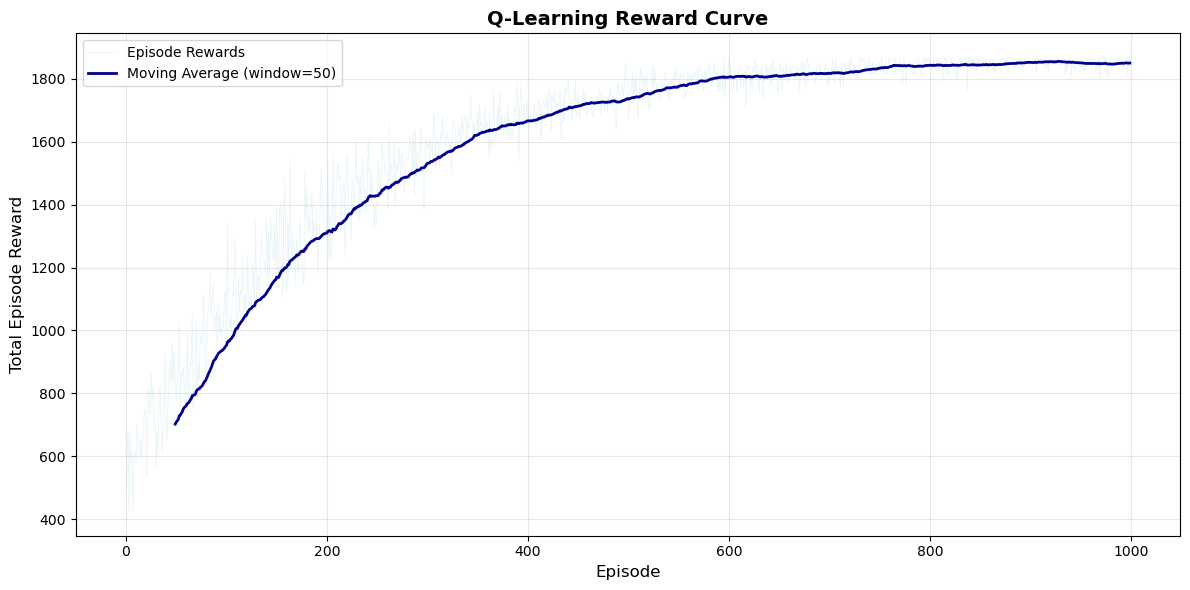


Reward Statistics:
  Initial average (first 100): 825.68
  Final average (last 100): 1850.56
  Maximum reward: 1872.00
  Minimum reward: 420.00


In [25]:
# Plot Reward Curve
print("=" * 80)
print("REWARD CURVE")
print("=" * 80)

# Calculate moving average for smoother visualization
window_size = 50
if len(episode_rewards) >= window_size:
    moving_avg = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
    episodes_avg = np.arange(window_size-1, len(episode_rewards))
else:
    moving_avg = episode_rewards
    episodes_avg = np.arange(len(episode_rewards))

plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, alpha=0.3, label='Episode Rewards', linewidth=0.5, color='lightblue')
plt.plot(episodes_avg, moving_avg, label=f'Moving Average (window={window_size})', 
         linewidth=2, color='darkblue')
plt.title('Q-Learning Reward Curve', fontsize=14, fontweight='bold')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Total Episode Reward', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nReward Statistics:")
print(f"  Initial average (first 100): {np.mean(episode_rewards[:100]):.2f}")
print(f"  Final average (last 100): {np.mean(episode_rewards[-100:]):.2f}")
print(f"  Maximum reward: {np.max(episode_rewards):.2f}")
print(f"  Minimum reward: {np.min(episode_rewards):.2f}")


ACTION DISTRIBUTION OVER TRAINING


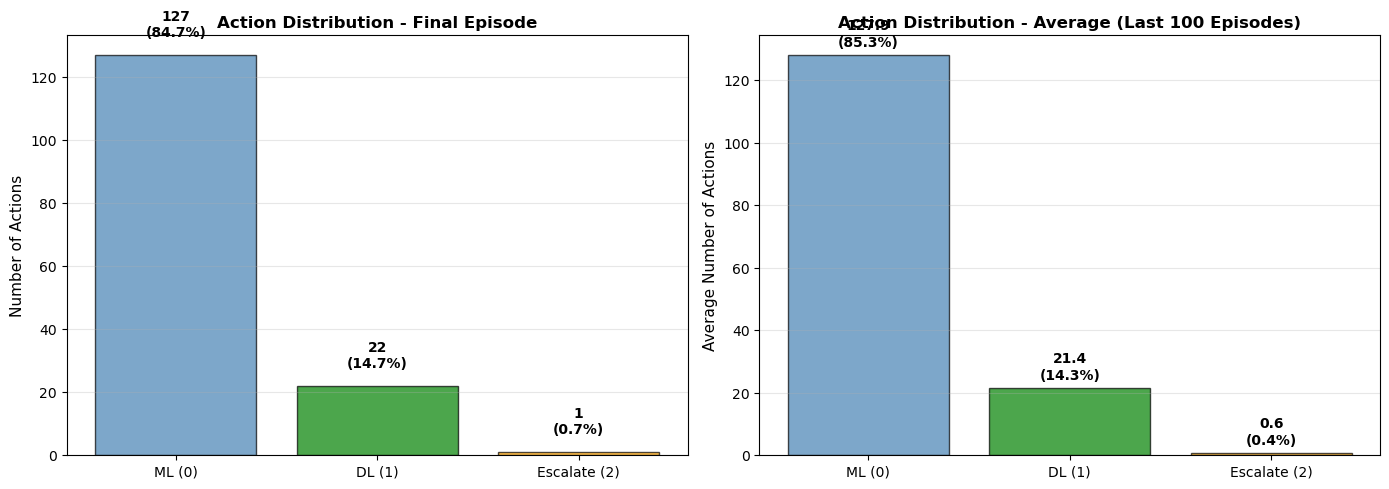


Action Distribution Statistics:

Final Episode:
  ML: 127 (84.67%)
  DL: 22 (14.67%)
  Escalate: 1 (0.67%)

Average (Last 100 Episodes):
  ML: 127.92 (85.28%)
  DL: 21.44 (14.29%)
  Escalate: 0.64 (0.43%)


In [26]:
# Plot Action Distribution
print("=" * 80)
print("ACTION DISTRIBUTION OVER TRAINING")
print("=" * 80)

# Calculate average action distribution over episodes
action_names = ['ML (0)', 'DL (1)', 'Escalate (2)']
action_colors = ['steelblue', 'green', 'orange']

# Final episode action distribution
final_actions = {
    0: episode_actions[0][-1],
    1: episode_actions[1][-1],
    2: episode_actions[2][-1]
}
total_final = sum(final_actions.values())

# Average over last 100 episodes
avg_actions_last_100 = {
    0: np.mean(episode_actions[0][-100:]),
    1: np.mean(episode_actions[1][-100:]),
    2: np.mean(episode_actions[2][-100:])
}
total_avg = sum(avg_actions_last_100.values())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Final episode distribution
axes[0].bar(action_names, [final_actions[i] for i in [0, 1, 2]], 
           color=action_colors, edgecolor='black', alpha=0.7)
axes[0].set_title('Action Distribution - Final Episode', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Actions', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
for i, (name, count) in enumerate(zip(action_names, [final_actions[j] for j in [0, 1, 2]])):
    pct = count / total_final * 100
    axes[0].text(i, count + 5, f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Average over last 100 episodes
axes[1].bar(action_names, [avg_actions_last_100[i] for i in [0, 1, 2]], 
           color=action_colors, edgecolor='black', alpha=0.7)
axes[1].set_title('Action Distribution - Average (Last 100 Episodes)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Number of Actions', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)
for i, (name, count) in enumerate(zip(action_names, [avg_actions_last_100[j] for j in [0, 1, 2]])):
    pct = count / total_avg * 100
    axes[1].text(i, count + 2, f'{count:.1f}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nAction Distribution Statistics:")
print(f"\nFinal Episode:")
for i, name in enumerate(['ML', 'DL', 'Escalate']):
    pct = final_actions[i] / total_final * 100
    print(f"  {name}: {final_actions[i]} ({pct:.2f}%)")

print(f"\nAverage (Last 100 Episodes):")
for i, name in enumerate(['ML', 'DL', 'Escalate']):
    pct = avg_actions_last_100[i] / total_avg * 100
    print(f"  {name}: {avg_actions_last_100[i]:.2f} ({pct:.2f}%)")


RL AGENT PERFORMANCE EVALUATION

Accuracy Comparison:
  ML Model Accuracy: 0.9733
  DL Model Accuracy: 0.3400
  RL Agent Accuracy (non-escalated): 0.9800
  RL Escalation Rate: 0.00%


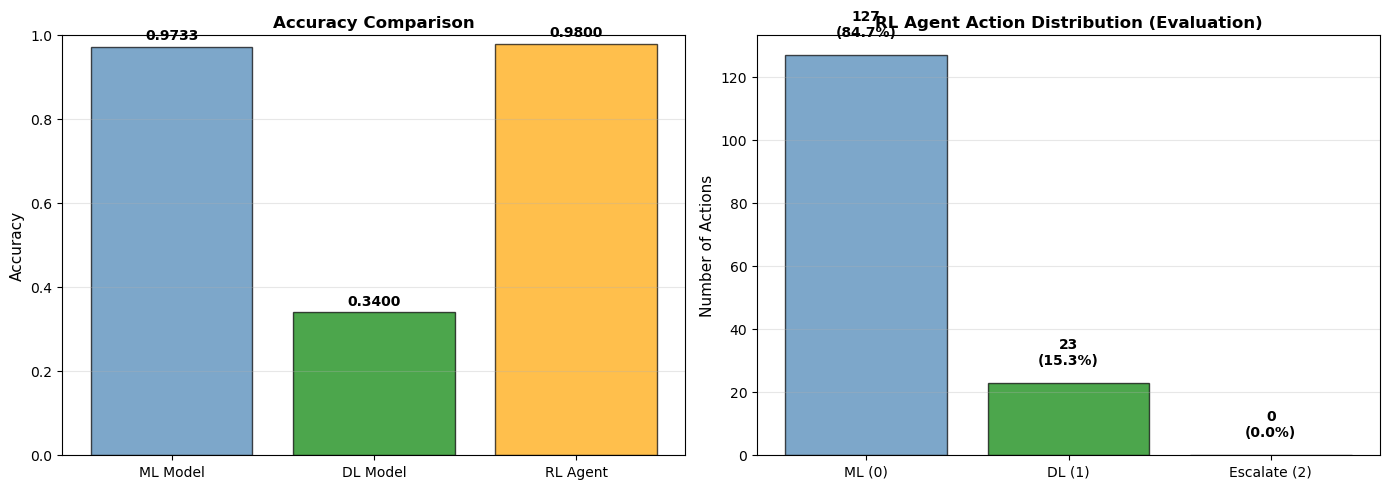

In [27]:
# Evaluate RL Agent Performance
print("=" * 80)
print("RL AGENT PERFORMANCE EVALUATION")
print("=" * 80)

# Set epsilon to 0 for evaluation (greedy policy)
agent.epsilon = 0

# Evaluate on test set
rl_predictions = []
rl_actions_taken = {0: 0, 1: 0, 2: 0}
rl_correct = 0

for idx in range(len(true_labels_test)):
    # Get state
    state = agent.get_state(
        ml_confidences[idx], dl_confidences[idx], test_cluster_ids[idx],
        test_article_lengths[idx], disagreement_flags[idx]
    )
    
    # Choose action (greedy)
    action = agent.choose_action(state)
    rl_actions_taken[action] += 1
    
    # Get prediction based on action
    if action == 0:  # Use ML
        pred = ml_predictions[idx]
    elif action == 1:  # Use DL
        pred = dl_predictions[idx]
    else:  # Escalate
        pred = -1  # Mark as escalate
    
    rl_predictions.append(pred)
    
    # Check if correct (only if not escalated)
    if action != 2 and pred == true_labels_test[idx]:
        rl_correct += 1

# Calculate accuracies
# For RL, only count non-escalated cases for accuracy
non_escalated_count = rl_actions_taken[0] + rl_actions_taken[1]
rl_accuracy = rl_correct / non_escalated_count if non_escalated_count > 0 else 0

ml_accuracy = (ml_predictions == true_labels_test).mean()
dl_accuracy = (dl_predictions == true_labels_test).mean()

print("\nAccuracy Comparison:")
print(f"  ML Model Accuracy: {ml_accuracy:.4f}")
print(f"  DL Model Accuracy: {dl_accuracy:.4f}")
print(f"  RL Agent Accuracy (non-escalated): {rl_accuracy:.4f}")
print(f"  RL Escalation Rate: {rl_actions_taken[2] / len(true_labels_test) * 100:.2f}%")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
accuracies = [ml_accuracy, dl_accuracy, rl_accuracy]
model_names = ['ML Model', 'DL Model', 'RL Agent']
colors = ['steelblue', 'green', 'orange']

axes[0].bar(model_names, accuracies, color=colors, edgecolor='black', alpha=0.7)
axes[0].set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, (name, acc) in enumerate(zip(model_names, accuracies)):
    axes[0].text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# RL action distribution during evaluation
action_names = ['ML (0)', 'DL (1)', 'Escalate (2)']
action_colors = ['steelblue', 'green', 'orange']
total_eval = sum(rl_actions_taken.values())
action_counts = [rl_actions_taken[i] for i in [0, 1, 2]]
action_pcts = [count / total_eval * 100 for count in action_counts]

axes[1].bar(action_names, action_counts, color=action_colors, edgecolor='black', alpha=0.7)
axes[1].set_title('RL Agent Action Distribution (Evaluation)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Actions', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)
for i, (name, count, pct) in enumerate(zip(action_names, action_counts, action_pcts)):
    axes[1].text(i, count + 5, f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [28]:
# Display Final Q-Table (Sample)
print("=" * 80)
print("FINAL Q-TABLE (Sample)")
print("=" * 80)

# Convert Q-table to a more readable format
q_table_df = []
for state, q_values in list(agent.q_table.items())[:50]:  # Show first 50 states
    ml_conf_bin, dl_conf_bin, cluster_bin, len_bin, disagreement = state
    q_table_df.append({
        'ML_Conf': ml_conf_bin,
        'DL_Conf': dl_conf_bin,
        'Cluster': cluster_bin,
        'Length': len_bin,
        'Disagree': disagreement,
        'Q(ML)': q_values[0],
        'Q(DL)': q_values[1],
        'Q(Escalate)': q_values[2],
        'Best Action': ACTIONS[np.argmax(q_values)]
    })

q_table_sample = pd.DataFrame(q_table_df)
print(f"\nSample of Q-table (showing first 50 states out of {len(agent.q_table)} total states):")
print(q_table_sample.to_string(index=False))

print(f"\nQ-Table Statistics:")
print(f"  Total states visited: {len(agent.q_table)}")
print(f"  Average Q-value (ML): {np.mean([q[0] for q in agent.q_table.values()]):.4f}")
print(f"  Average Q-value (DL): {np.mean([q[1] for q in agent.q_table.values()]):.4f}")
print(f"  Average Q-value (Escalate): {np.mean([q[2] for q in agent.q_table.values()]):.4f}")

# Count best actions
best_actions = [np.argmax(q) for q in agent.q_table.values()]
best_action_counts = Counter(best_actions)
print(f"\nBest Action Distribution (based on Q-values):")
for action_id, action_name in enumerate(['ML', 'DL', 'Escalate']):
    count = best_action_counts.get(action_id, 0)
    pct = count / len(agent.q_table) * 100
    print(f"  {action_name}: {count} ({pct:.2f}%)")


FINAL Q-TABLE (Sample)

Sample of Q-table (showing first 50 states out of 43 total states):
 ML_Conf  DL_Conf  Cluster  Length  Disagree      Q(ML)      Q(DL)  Q(Escalate)  Best Action
       2        1        0       0         0 239.984453 240.000000   226.992474            1
       2        1        4       0         1 260.000000 240.000000   246.000000            0
       3        1        0       0         0 239.997482 240.000000   226.999707            1
       2        1        0       0         1 260.000000 240.000000   246.000000            0
       3        2        4       0         0 200.788143 236.942969   175.933397            1
       2        1        4       0         0 197.328701 236.966544   159.178565            1
       3        1        3       0         1 260.000000 240.000000   246.000000            0
       3        1        4       0         1 259.958672 232.122829   235.350500            0
       3        1        2       0         0 240.000000 240.000000   22

In [30]:
# Summary Statistics
print("=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

print("\nPart A: Data Preprocessing")
print(f"  - Total articles: {len(df)}")
print(f"  - Categories: {', '.join(df['category'].unique())}")
print(f"  - TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"  - Token sequence max length: {max_length}")

print("\nPart B: News Classifiers")
print(f"  - ML Model (Logistic Regression) Accuracy: {accuracy_ml:.4f}")
print(f"  - ML Model Weighted F1: {overall_f1_ml:.4f}")
print(f"  - DL Model (LSTM) Accuracy: {test_accuracy:.4f}")
print(f"  - DL Model Weighted F1: {overall_f1_dl:.4f}")

print("\nPart C: Topic Clustering")
print(f"  - Number of clusters: {n_clusters}")
print(f"  - Clustering method: k-Means")
print(f"  - Embedding method: TF-IDF")

print("\nPart D: RL Decision Agent")
print(f"  - Training episodes: 1000")
print(f"  - RL Agent Accuracy: {rl_accuracy:.4f}")
print(f"  - Escalation rate: {rl_actions_taken[2] / len(true_labels_test) * 100:.2f}%")
print(f"  - Final epsilon: {agent.epsilon:.4f}")
print(f"  - States explored: {len(agent.q_table)}")

print("\n" + "="*80)
print("Assignment Complete!")
print("="*80)


FINAL SUMMARY

Part A: Data Preprocessing
  - Total articles: 750
  - Categories: business, entertainment, politics, sport, tech
  - TF-IDF vocabulary size: 3000
  - Token sequence max length: 300

Part B: News Classifiers
  - ML Model (Logistic Regression) Accuracy: 0.9733
  - ML Model Weighted F1: 0.9734
  - DL Model (LSTM) Accuracy: 0.3400
  - DL Model Weighted F1: 0.2617

Part C: Topic Clustering
  - Number of clusters: 5
  - Clustering method: k-Means
  - Embedding method: TF-IDF

Part D: RL Decision Agent
  - Training episodes: 1000
  - RL Agent Accuracy: 0.9800
  - Escalation rate: 0.00%
  - Final epsilon: 0.0000
  - States explored: 43

Assignment Complete!
